In [1]:
%%javascript
// Run for table of contents.
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

// https://github.com/kmahelona/ipython_notebook_goodies

<IPython.core.display.Javascript object>

# Testing "ldasimple" with NIPS data

<h2 id="tocheading">Table of Contents</h2>
<div id="toc"></div>


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary
from imp import reload

import logging

import ldasimple
from ldasimple import BatchLda
from ldasimple import batchlda
from ldasimple import OnlineLda
from ldasimple import onlinelda

from gensim.models import LdaModel

%matplotlib inline

In [3]:
# Configure logging.
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='../../log_files/log.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

## Load and pre-process data

In [134]:
import os
import re

# Folder containing all NIPS papers.
data_dir = '../../../data/nipstxt/'

# Folders containin individual NIPS papers.
#yrs = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
yrs = ['02']
dirs = ['nips' + yr for yr in yrs]

# Get all document texts and their corresponding IDs.
docs = []
doc_ids = []
for yr_dir in dirs:
    files = os.listdir(data_dir + yr_dir)  # List of filenames.
    for filen in files:
        # Get document ID.
        (idx1, idx2) = re.search('[0-9]+', filen).span()  # Matches the indexes of the start end end of the ID.
        doc_ids.append(yr_dir[4:] + '_' + str(int(filen[idx1:idx2])))
        
        # Read document text.
        # Note: ignoring characters that cause encoding errors.
        with open(data_dir + yr_dir + '/' + filen, errors='ignore', encoding='utf-8') as fid:
            txt = fid.read()
        docs.append(txt)

In [135]:
filenames = [data_dir + 'idx/a' + yr + '.txt' for yr in yrs]  # Using the years defined in previous cell.

# Get all author names and their corresponding document IDs.
authors_names = []
author2doc = {}
author_id = 0
for yr in yrs:
    filename = data_dir + 'idx/a' + yr + '.txt'
    for line in open(filename, errors='ignore', encoding='utf-8'):
        contents = re.split(',', line)
        author_name = (contents[1] + contents[0]).strip()
        ids = [c.strip() for c in contents[2:]]
        authors_names.append(author_name)
        author2doc[author_id] = [yr + '_' + id for id in ids]
        author_id += 1

In [136]:
# Tokenize the documents.

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

In [137]:
# Lemmatize the documents.

# Lemmatize all words in documents.
lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [138]:
# Compute bigrams.

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [139]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

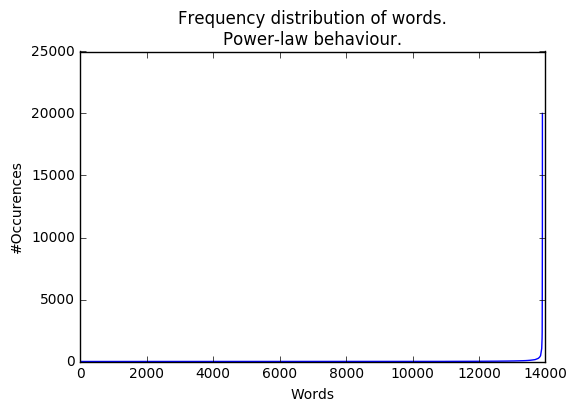

In [140]:
# Frequency distribution of words.

one_doc = []
for doc in docs:
    one_doc.extend(doc)

bow = dictionary.doc2bow(one_doc)
word_freq = [cnt for _, cnt in bow]

plt.plot(sorted(word_freq))
plt.xlabel('Words')
plt.ylabel('#Occurences')
plt.title('Frequency distribution of words.\nPower-law behaviour.')
plt.show()

In [141]:
# Remove rare and common tokens.

# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 20
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

dict0 = dictionary[0]  # This sort of "initializes" dictionary.id2token.

In [142]:
# Vectorize data.

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [143]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 677
Number of documents: 101


In [144]:
input_corpus = corpus[:]

In [145]:
print('phi is %d x %d x %d (%d elements)' %(len(small_corpus), len(dictionary.id2token), 10,
                                            len(small_corpus) * len(dictionary.id2token) * 10))

phi is 10 x 677 x 10 (67700 elements)


In [152]:
reload(batchlda)
BatchLda = batchlda.BatchLda

In [153]:
%time model = BatchLda(corpus=input_corpus, num_topics=10, id2word=dictionary.id2token, \
            threshold=0.001, iterations=10, alpha=None, eta=None, \
            eval_every=0, random_state=0)

CPU times: user 2min 4s, sys: 120 ms, total: 2min 5s
Wall time: 2min 4s


In [101]:
model.show_topics()

[(0,
  '0.032*training + 0.025*representation + 0.023*region + 0.021*feature + 0.020*decision + 0.019*node + 0.017*back + 0.014*propagation + 0.014*hidden + 0.013*back_propagation'),
 (1,
  '0.031*image + 0.021*processor + 0.013*current + 0.012*matrix + 0.011*code + 0.010*device + 0.010*hopfield + 0.009*edge + 0.008*mapping + 0.008*scale'),
 (2,
  '0.043*cell + 0.018*firing + 0.014*node + 0.014*temporal + 0.014*potential + 0.011*rate + 0.010*synaptic + 0.010*spatial + 0.010*frequency + 0.009*stimulus'),
 (3,
  '0.029*dynamic + 0.025*matrix + 0.014*hopfield + 0.014*delay + 0.014*capacity + 0.012*sequence + 0.012*energy + 0.011*noise + 0.010*hidden + 0.009*minimum'),
 (4,
  '0.028*hidden + 0.019*convergence + 0.012*synaptic + 0.010*hidden_unit + 0.009*vol + 0.008*procedure + 0.008*bit + 0.008*training + 0.007*channel + 0.007*array'),
 (5,
  '0.047*cell + 0.030*stimulus + 0.022*activity + 0.021*field + 0.012*probability + 0.010*constraint + 0.010*synaptic + 0.009*produced + 0.009*potentia

## Online LDA simple

In [154]:
reload(onlinelda)
OnlineLda = onlinelda.OnlineLda

In [155]:
%time model = OnlineLda(corpus=input_corpus, num_topics=10, id2word=dictionary.id2token, \
            threshold=1e-10, iterations=100, alpha=None, eta=None, passes=1, \
            offset=1.0, decay=0.5, eval_every=0, random_state=0)

CPU times: user 2min 28s, sys: 60 ms, total: 2min 28s
Wall time: 2min 28s


### LdaModel on the same data

In [156]:
%time model = LdaModel(corpus=input_corpus, num_topics=10, id2word=dictionary.id2token, \
                        alpha='symmetric', eta='symmetric', random_state=0, gamma_threshold=1e-30, \
                        iterations=100, eval_every=1, chunksize=1)

CPU times: user 3.76 s, sys: 16 ms, total: 3.78 s
Wall time: 3.79 s


In [157]:
corpus_words = sum(cnt for document in corpus for _, cnt in document)
model.bound(corpus) / corpus_words

-6.4719095715703547

In [158]:
model.show_topics()

[(0,
  '0.058*recognition + 0.041*frequency + 0.026*hidden_layer + 0.025*hidden + 0.025*train + 0.024*trained + 0.022*four + 0.020*pp + 0.019*delay + 0.018*resulting'),
 (1,
  '0.087*cell + 0.063*map + 0.054*threshold + 0.049*synapsis + 0.046*view + 0.042*brain + 0.041*et + 0.041*location + 0.040*synaptic + 0.038*et_al'),
 (2,
  '0.035*optimal + 0.031*component + 0.027*matrix + 0.026*target + 0.022*estimate + 0.022*direction + 0.022*limit + 0.021*de + 0.020*positive + 0.020*sum'),
 (3,
  '0.036*memory + 0.034*image + 0.027*noise + 0.018*vector + 0.015*address + 0.014*classification + 0.014*sample + 0.014*dimensional + 0.013*class + 0.012*maximum'),
 (4,
  '0.069*control + 0.066*highly + 0.057*environment + 0.044*rather_than + 0.040*actually + 0.038*prior + 0.036*minimum + 0.033*modification + 0.030*normal + 0.028*square'),
 (5,
  '0.034*node + 0.030*equation + 0.026*back + 0.026*propagation + 0.023*back_propagation + 0.021*hidden + 0.020*behavior + 0.016*standard + 0.016*line + 0.016*c